In [25]:
# Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score
from dmba import regressionSummary, classificationSummary
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# EDA

In [8]:
data = pd.read_csv("./card_transdata.csv")
data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [9]:
# Rename the columns to capitalize and replace spaces with underscores
data.columns = [col.upper().replace(' ', '_') for col in data.columns]
# Checking null values for each column
print(data.isna().sum())

DISTANCE_FROM_HOME                0
DISTANCE_FROM_LAST_TRANSACTION    0
RATIO_TO_MEDIAN_PURCHASE_PRICE    0
REPEAT_RETAILER                   0
USED_CHIP                         0
USED_PIN_NUMBER                   0
ONLINE_ORDER                      0
FRAUD                             0
dtype: int64


In [10]:
# Checking total number of rows and columns
data.shape

(1000000, 8)

In [11]:
data.describe()

,DISTANCE_FROM_HOME,DISTANCE_FROM_LAST_TRANSACTION,RATIO_TO_MEDIAN_PURCHASE_PRICE,REPEAT_RETAILER,USED_CHIP,USED_PIN_NUMBER,ONLINE_ORDER,FRAUD
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


# Data Preparation | Feature Engineering

In [12]:
# Calculating change in distance from the previous transaction
data['DISTANCE_RATIO'] = data['DISTANCE_FROM_HOME'] / data['DISTANCE_FROM_LAST_TRANSACTION']

In [13]:
min_value = data['RATIO_TO_MEDIAN_PURCHASE_PRICE'].min()
max_value = data['RATIO_TO_MEDIAN_PURCHASE_PRICE'].max()
data['RATIO_NORMALIZED'] = (data['RATIO_TO_MEDIAN_PURCHASE_PRICE'] - min_value) / (max_value - min_value)

data.head(5)

,DISTANCE_FROM_HOME,DISTANCE_FROM_LAST_TRANSACTION,RATIO_TO_MEDIAN_PURCHASE_PRICE,REPEAT_RETAILER,USED_CHIP,USED_PIN_NUMBER,ONLINE_ORDER,FRAUD,DISTANCE_RATIO,RATIO_NORMALIZED
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0,186.018690,0.007250
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0,61.676918,0.004816
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0,6.323124,0.001581
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0,0.401348,0.001338
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0,78.008839,0.008284


In [14]:
# Normalize the 'DISTANCE_FROM_HOME' feature
data['DISTANCE_NORMALIZED'] = (data['DISTANCE_FROM_HOME'] - data['DISTANCE_FROM_HOME'].mean()) / data['DISTANCE_FROM_HOME'].std()

# Define bin edges based on quartiles
bin_edges = [data['DISTANCE_NORMALIZED'].min(), data['DISTANCE_NORMALIZED'].quantile(0.25), data['DISTANCE_NORMALIZED'].quantile(0.5), data['DISTANCE_NORMALIZED'].quantile(0.75), data['DISTANCE_NORMALIZED'].max()]

# Bin the data
data['DISTANCE_CATEGORY'] = pd.cut(data['DISTANCE_NORMALIZED'], bins=bin_edges, labels=False)

# Create binary indicators for the bins
data['DISTANCE_NEAR'] = (data['DISTANCE_CATEGORY'] == 0).astype(int)
data['DISTANCE_MEDIUM'] = (data['DISTANCE_CATEGORY'] == 1).astype(int)
data['DISTANCE_FAR'] = (data['DISTANCE_CATEGORY'] == 2).astype(int)
data['DISTANCE_VERY_FAR'] = (data['DISTANCE_CATEGORY'] == 3).astype(int)

# Drop the intermediate columns as required needed anymore
data.drop(columns=['DISTANCE_NORMALIZED', 'DISTANCE_CATEGORY'], inplace=True)

In [15]:
# Rename the column 'RATIO_NORMALIZED' to 'RATIO_TO_MEDIAN_PURCHASE_NORMALIZED'
data.rename(columns={'RATIO_NORMALIZED': 'RATIO_TO_MEDIAN_PURCHASE_NORMALIZED'}, inplace=True)

# Move the target variable 'FRAUD' to the last position of the columns
fraud_column = data.pop('FRAUD')  # Remove 'FRAUD' column and store it
data['FRAUD'] = fraud_column  # Add 'FRAUD' column to the end of the DataFrame

# Get the current column order
current_columns = data.columns.tolist()

# Reorder the columns
desired_columns_order = ['DISTANCE_FROM_HOME', 'DISTANCE_FROM_LAST_TRANSACTION', 'DISTANCE_RATIO'] + [col for col in current_columns if col not in ['DISTANCE_FROM_HOME', 'DISTANCE_FROM_LAST_TRANSACTION', 'DISTANCE_RATIO']]
data = data[desired_columns_order]

data.head(5)

,DISTANCE_FROM_HOME,DISTANCE_FROM_LAST_TRANSACTION,DISTANCE_RATIO,RATIO_TO_MEDIAN_PURCHASE_PRICE,REPEAT_RETAILER,USED_CHIP,USED_PIN_NUMBER,ONLINE_ORDER,RATIO_TO_MEDIAN_PURCHASE_NORMALIZED,DISTANCE_NEAR,DISTANCE_MEDIUM,DISTANCE_FAR,DISTANCE_VERY_FAR,FRAUD
0,57.877857,0.311140,186.018690,1.945940,1.0,1.0,0.0,0.0,0.007250,0,0,0,1,0.0
1,10.829943,0.175592,61.676918,1.294219,1.0,0.0,0.0,0.0,0.004816,0,0,1,0,0.0
2,5.091079,0.805153,6.323124,0.427715,1.0,0.0,0.0,1.0,0.001581,0,1,0,0,0.0
3,2.247564,5.600044,0.401348,0.362663,1.0,1.0,0.0,1.0,0.001338,1,0,0,0,0.0
4,44.190936,0.566486,78.008839,2.222767,1.0,1.0,0.0,1.0,0.008284,0,0,0,1,0.0


# Pre-Processing | Feature Selection

In [16]:
# Count the values of 0 and 1 in the 'FRAUD' column
fraud_counts = data['FRAUD'].value_counts()

# Calculate the percentage of fraudulent transactions
fraud_ratio = fraud_counts[1] / fraud_counts[0] * 100

# Display the results
print("Number of fraudulent transactions (FRAUD = 1):", fraud_counts[1])
print("Number of non-fraudulent transactions (FRAUD = 0):", fraud_counts[0])
print("\nPercentage of fraudulent transactions: {:.2f}%".format(fraud_ratio))

Number of fraudulent transactions (FRAUD = 1): 87403
Number of non-fraudulent transactions (FRAUD = 0): 912597

Percentage of fraudulent transactions: 9.58%


In [17]:
# Set a random seed for reproducibility
np.random.seed(42)

# Create a subset of the dataset with 50,000 randomly selected datapoints
subset_data = data.sample(n=50000)

# Count the values of 0 and 1 in the 'FRAUD' column for the subset
subset_fraud_counts = subset_data['FRAUD'].value_counts()

# Calculate the percentage of fraudulent transactions for the subset
subset_ratio = (subset_fraud_counts[1] / subset_fraud_counts[0]) * 100

# Display the results
print("Number of fraudulent transactions (FRAUD = 1):", subset_fraud_counts[1])
print("Number of non-fraudulent transactions (FRAUD = 0):", subset_fraud_counts[0])
print("\nPercentage of fraudulent transactions in the subset: {:.2f}%".format(subset_ratio))

Number of fraudulent transactions (FRAUD = 1): 4309
Number of non-fraudulent transactions (FRAUD = 0): 45691

Percentage of fraudulent transactions in the subset: 9.43%


In [18]:
subset_data.describe()

,DISTANCE_FROM_HOME,DISTANCE_FROM_LAST_TRANSACTION,DISTANCE_RATIO,RATIO_TO_MEDIAN_PURCHASE_PRICE,REPEAT_RETAILER,USED_CHIP,USED_PIN_NUMBER,ONLINE_ORDER,RATIO_TO_MEDIAN_PURCHASE_NORMALIZED,DISTANCE_NEAR,DISTANCE_MEDIUM,DISTANCE_FAR,DISTANCE_VERY_FAR,FRAUD
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000
mean,26.549348,5.220660,130.443990,1.811345,0.881340,0.35056,0.100060,0.651740,0.006747,0.251260,0.250720,0.249120,0.24890,0.086180
std,78.627567,22.001490,1243.645400,2.818171,0.323391,0.47715,0.300083,0.476424,0.010523,0.433742,0.433432,0.432508,0.43238,0.280632
min,0.024144,0.000539,0.000417,0.006125,0.000000,0.00000,0.000000,0.000000,0.000006,0.000000,0.000000,0.000000,0.00000,0.000000
25%,3.858004,0.300434,2.070775,0.472395,1.000000,0.00000,0.000000,0.000000,0.001748,0.000000,0.000000,0.000000,0.00000,0.000000
50%,9.907588,1.018955,9.732563,0.990188,1.000000,0.00000,0.000000,1.000000,0.003681,0.000000,0.000000,0.000000,0.00000,0.000000
75%,25.626905,3.379200,45.739591,2.070817,1.000000,1.00000,0.000000,1.000000,0.007716,1.000000,1.000000,0.000000,0.00000,0.000000
max,10632.723672,1400.098234,138559.932816,99.942349,1.000000,1.00000,1.000000,1.000000,0.373183,1.000000,1.000000,1.000000,1.00000,1.000000


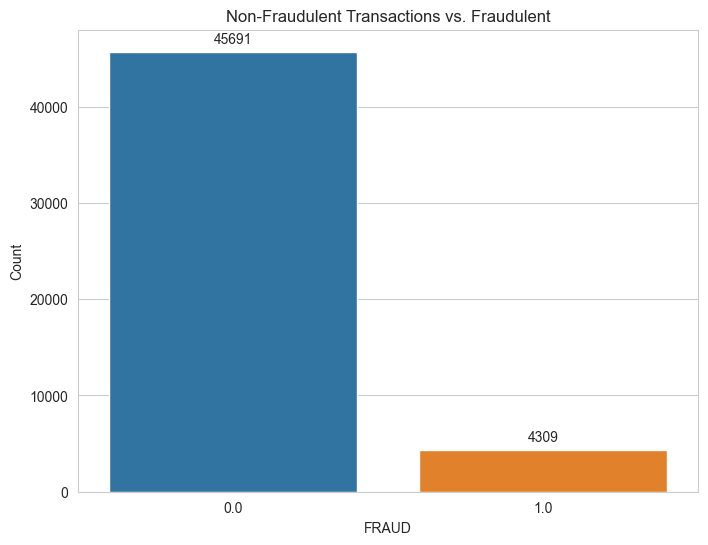

In [19]:
# Bar Plot of Fraudulent vs. Non-Fraudulent Transactions
sns.set_style("whitegrid")

# Plotting the bar plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=subset_data, x='FRAUD')
plt.title('Non-Fraudulent Transactions vs. Fraudulent')
plt.xlabel('FRAUD')
plt.ylabel('Count')

# Adding data labels
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

plt.show()

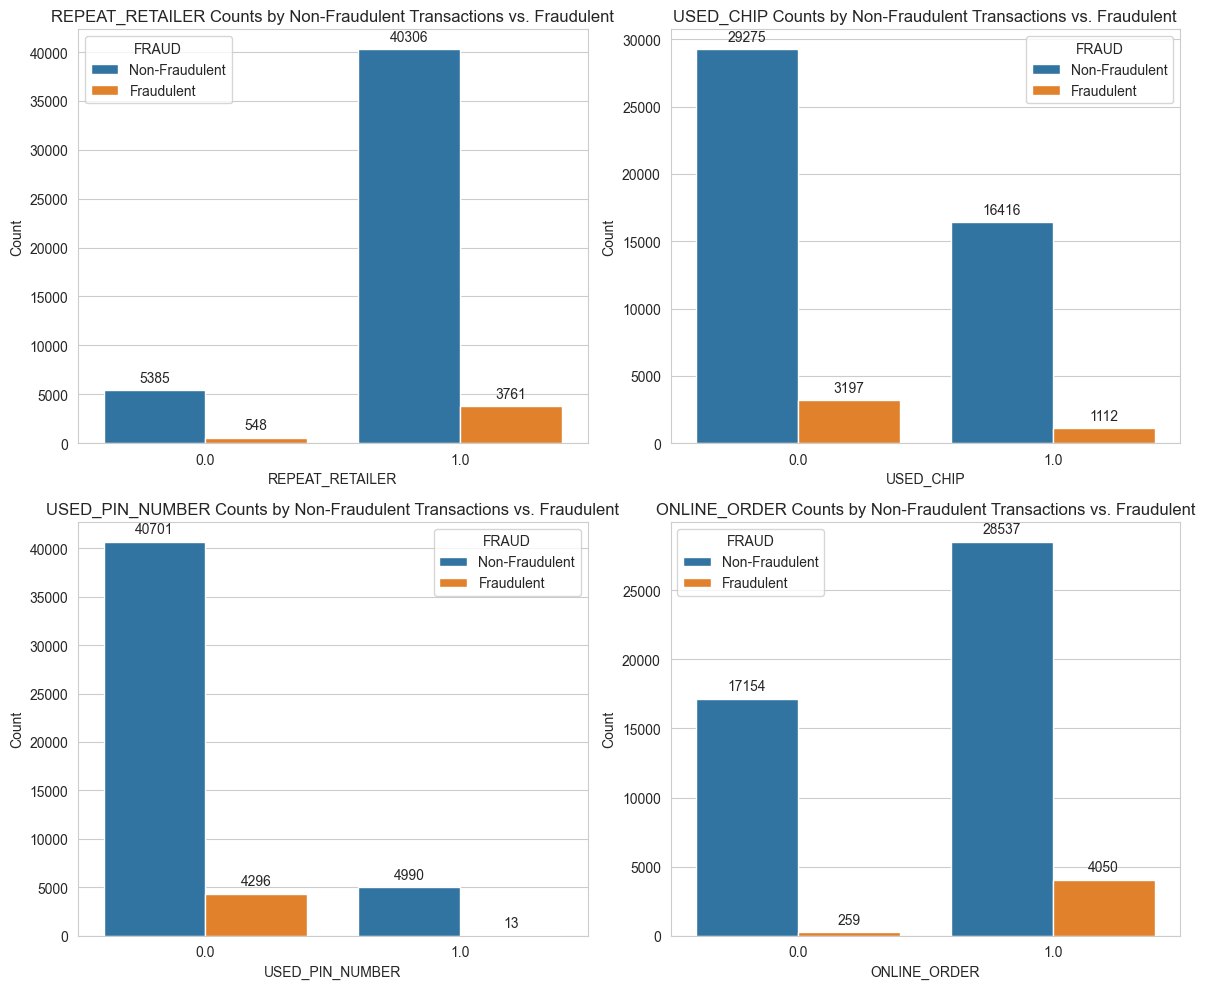

In [20]:
# Bar Plot of Fraudulent vs. Non-Fraudulent Transactions by Purchased Method
sns.set_style("whitegrid")

# Define the categorical features you want to compare
categorical_features = ['REPEAT_RETAILER', 'USED_CHIP', 'USED_PIN_NUMBER', 'ONLINE_ORDER']

# Plotting the bar plots for each categorical feature in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    ax = sns.countplot(data=subset_data, x=feature, hue='FRAUD', ax=axes[i])
    ax.set_title(f'{feature} Counts by Non-Fraudulent Transactions vs. Fraudulent')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    ax.legend(title='FRAUD', labels=['Non-Fraudulent', 'Fraudulent'])
    
    # Adding data labels
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

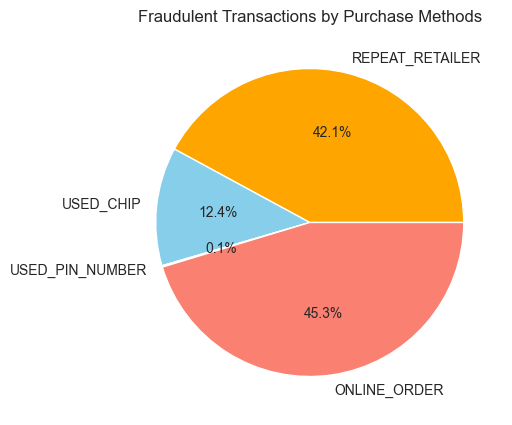

In [21]:
# Pie Diagram of Fraudulent Transactions Percentage by Purchased Methods
purchase_methods = ['REPEAT_RETAILER', 'USED_CHIP', 'USED_PIN_NUMBER', 'ONLINE_ORDER']

# Plotting the count of fraudulent transactions for each purchase method using a pie chart
plt.figure(figsize=(5, 5))

# Iterate through each purchase method and calculate the count of fraudulent transactions
fraudulent_counts = [subset_data[subset_data[method] == 1]['FRAUD'].sum() for method in purchase_methods]

# Plot the pie chart
plt.pie(fraudulent_counts, labels=purchase_methods, autopct='%1.1f%%', colors=['orange', 'skyblue', 'lightgreen', 'salmon'])

# Set title
plt.title('Fraudulent Transactions by Purchase Methods')

plt.show()

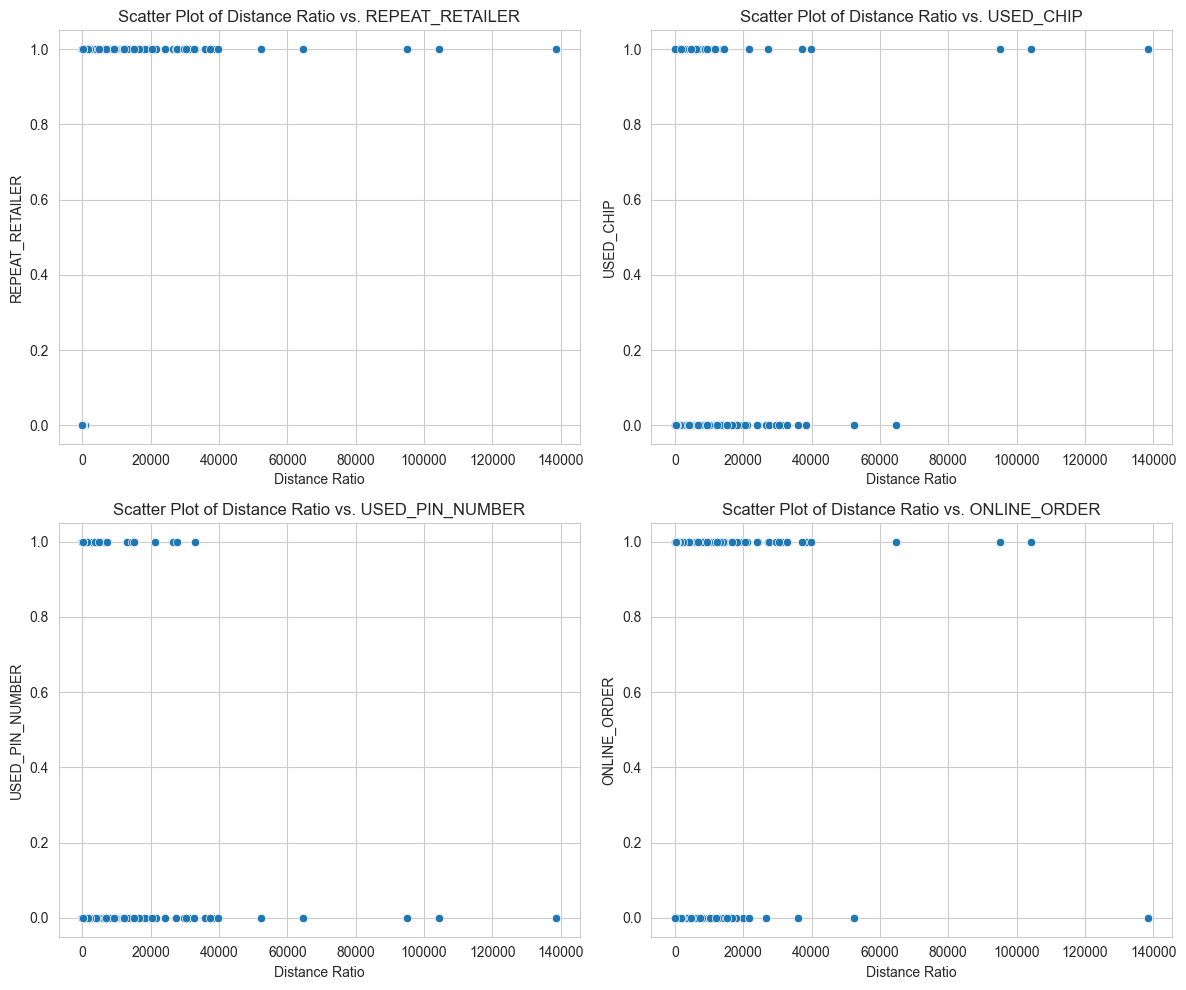

In [22]:
# Scatter Plot of Distance Ratio vs Purchase Methods
sns.set_style("whitegrid")

# Purchase methods to compare
purchase_methods = ['REPEAT_RETAILER', 'USED_CHIP', 'USED_PIN_NUMBER', 'ONLINE_ORDER']

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through each purchase method and plot the scatter plot in each subplot
for i, method in enumerate(purchase_methods):
    sns.scatterplot(data=subset_data, x='DISTANCE_RATIO', y=method, ax=axes[i])
    axes[i].set_xlabel('Distance Ratio')
    axes[i].set_ylabel(method)
    axes[i].set_title(f'Scatter Plot of Distance Ratio vs. {method}')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

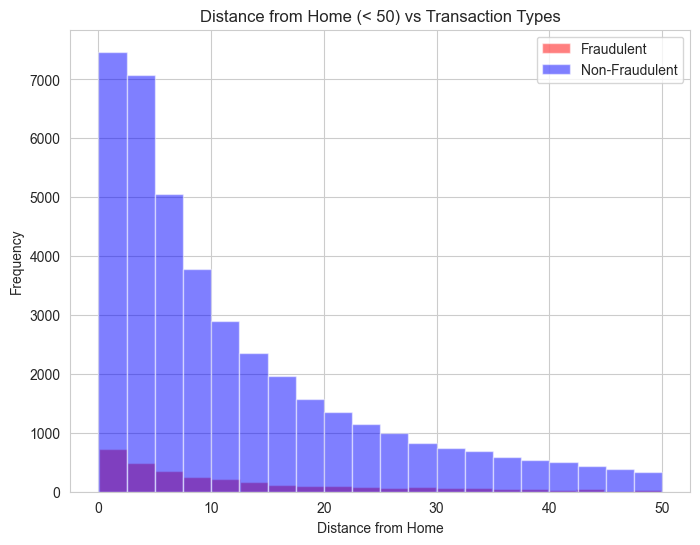

In [23]:
# Histogram of Distance from Home (Values < 50) vs Transaction Types

# Filter data by fraud category and distance from home values less than 50
fraudulent_transactions = subset_data[(subset_data['FRAUD'] == 1) & (subset_data['DISTANCE_FROM_HOME'] < 50)]['DISTANCE_FROM_HOME']
non_fraudulent_transactions = subset_data[(subset_data['FRAUD'] == 0) & (subset_data['DISTANCE_FROM_HOME'] < 50)]['DISTANCE_FROM_HOME']

# Create a figure with a specified size
plt.figure(figsize=(8, 6))

# Create a histogram
plt.hist(fraudulent_transactions, bins=20, alpha=0.5, color='red', label='Fraudulent')
plt.hist(non_fraudulent_transactions, bins=20, alpha=0.5, color='blue', label='Non-Fraudulent')

plt.xlabel('Distance from Home')
plt.ylabel('Frequency')
plt.title('Distance from Home (< 50) vs Transaction Types')
plt.legend()

# Show the histogram
plt.show()

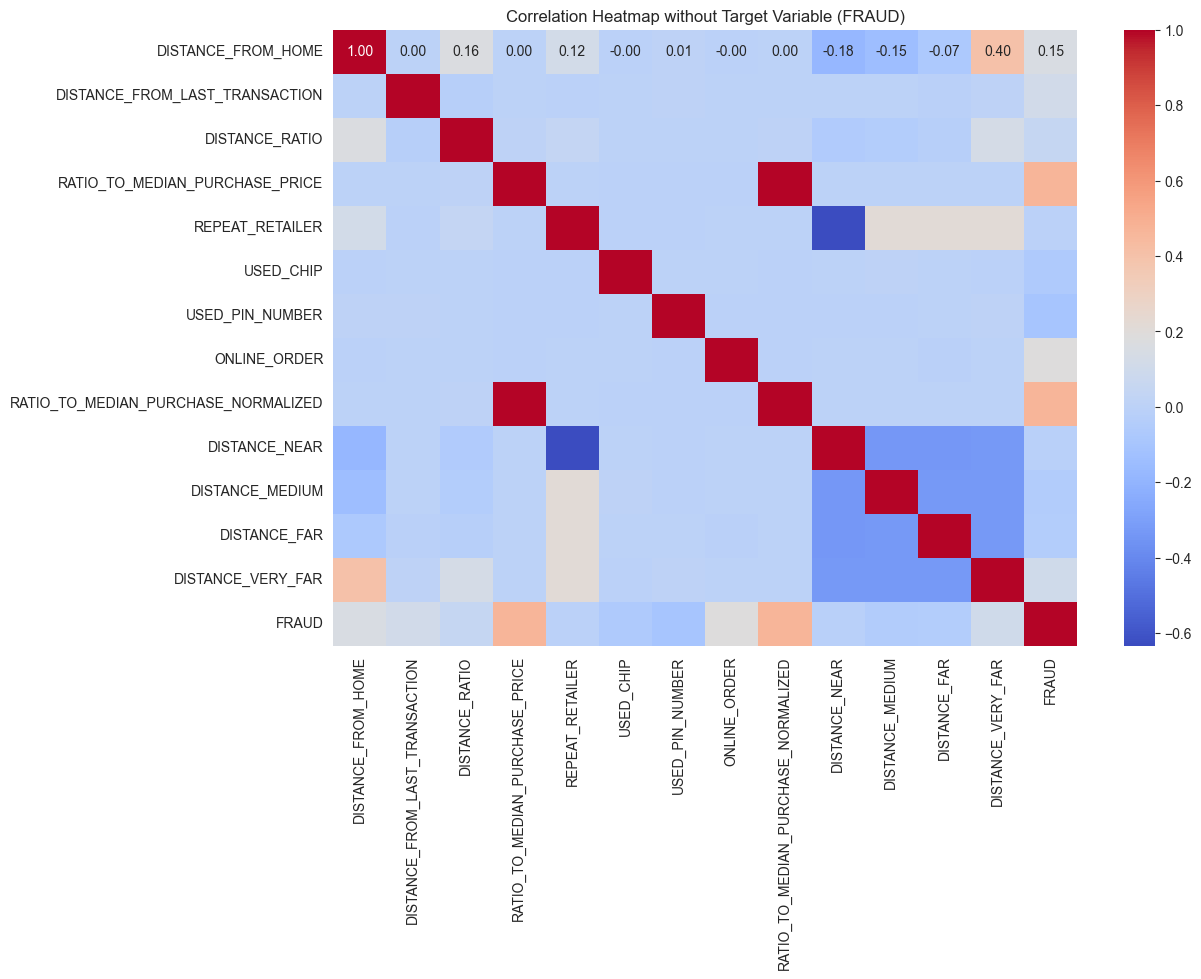

In [24]:
# Correlation Heatmap
correlation_matrix = subset_data.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap without Target Variable (FRAUD)')
plt.show()

# Modeling | Evaluation

### Linear Regression

In [26]:
predictors = ['DISTANCE_FROM_HOME', 'DISTANCE_FROM_LAST_TRANSACTION', 'ONLINE_ORDER', 'RATIO_TO_MEDIAN_PURCHASE_NORMALIZED', 'DISTANCE_VERY_FAR']
outcome = 'FRAUD'

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(subset_data[predictors], subset_data[outcome], test_size=0.4, random_state=42)

# Fit linear regression model
lm_model = LinearRegression()
lm_model.fit(X_train, y_train)

# Predict on the test set
y_pred = lm_model.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root Mean Squared Error: {rmse:.4f}")

Root Mean Squared Error: 0.2442


In [27]:
regressionSummary(y_train, lm_model.predict(X_train))


Regression statistics

               Mean Error (ME) : -0.0000
Root Mean Squared Error (RMSE) : 0.2335
     Mean Absolute Error (MAE) : 0.1336


In [28]:
regressionSummary(y_test, lm_model.predict(X_test))


Regression statistics

               Mean Error (ME) : -0.0012
Root Mean Squared Error (RMSE) : 0.2442
     Mean Absolute Error (MAE) : 0.1359


In [29]:
# Generate predictions using the trained linear regression model and compare with actual values
model_pred = lm_model.predict(X_test)
result = pd.DataFrame({'Predicted': model_pred, 'Actual': y_test, 'Residual': y_test - model_pred})
print(result.head(20))

        Predicted  Actual  Residual
307655   0.063289     0.0 -0.063289
812167   0.051933     0.0 -0.051933
62036    0.084719     0.0 -0.084719
620564  -0.033361     0.0  0.033361
256756   0.084179     0.0 -0.084179
768798   0.057021     0.0 -0.057021
863904   0.096770     0.0 -0.096770
282225   0.212293     0.0 -0.212293
480643   0.035259     0.0 -0.035259
195897   0.224756     0.0 -0.224756
867567   0.044653     0.0 -0.044653
784314   0.284150     1.0  0.715850
197692   0.149100     0.0 -0.149100
145450   0.087809     0.0 -0.087809
44184    0.045827     0.0 -0.045827
296982   0.062155     0.0 -0.062155
590909  -0.073820     0.0  0.073820
596436   0.096875     0.0 -0.096875
422211   0.022783     0.0 -0.022783
922709   0.023447     0.0 -0.023447


### Naive Bayes

In [30]:
predictors = ['DISTANCE_FROM_HOME', 'DISTANCE_FROM_LAST_TRANSACTION', 'ONLINE_ORDER', 'RATIO_TO_MEDIAN_PURCHASE_NORMALIZED', 'DISTANCE_VERY_FAR']
outcome = 'FRAUD'

# Extract predictors and outcome variable from the dataset
X = subset_data[predictors]
y = subset_data[outcome]

# Split data into training and testing sets
X_train, X_test, y_train, y1_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Initialize and fit Multinomial Naive Bayes classifier
model = MultinomialNB()
model.fit(X_train, y_train)

# Predict on the test set
y1_pred = model.predict(X_test)

# Calculate accuracy
accuracy_nb = accuracy_score(y1_test, y1_pred)
print("Accuracy: {:.4f}".format(accuracy_nb))

Accuracy: 0.8989


In [31]:
# Generate classification report
report = classification_report(y1_test, y1_pred)

# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95     18254
         1.0       0.28      0.10      0.14      1746

    accuracy                           0.90     20000
   macro avg       0.60      0.54      0.55     20000
weighted avg       0.86      0.90      0.88     20000



### K-Nearest Neighbour

k = 1, Accuracy = 0.8802
k = 2, Accuracy = 0.9109
k = 3, Accuracy = 0.9045
k = 4, Accuracy = 0.9117
k = 5, Accuracy = 0.9097
k = 6, Accuracy = 0.9133
k = 7, Accuracy = 0.9128
k = 8, Accuracy = 0.9141
k = 9, Accuracy = 0.9125
k = 10, Accuracy = 0.9135
k = 11, Accuracy = 0.9134
k = 12, Accuracy = 0.9134
k = 13, Accuracy = 0.9123
k = 14, Accuracy = 0.9127


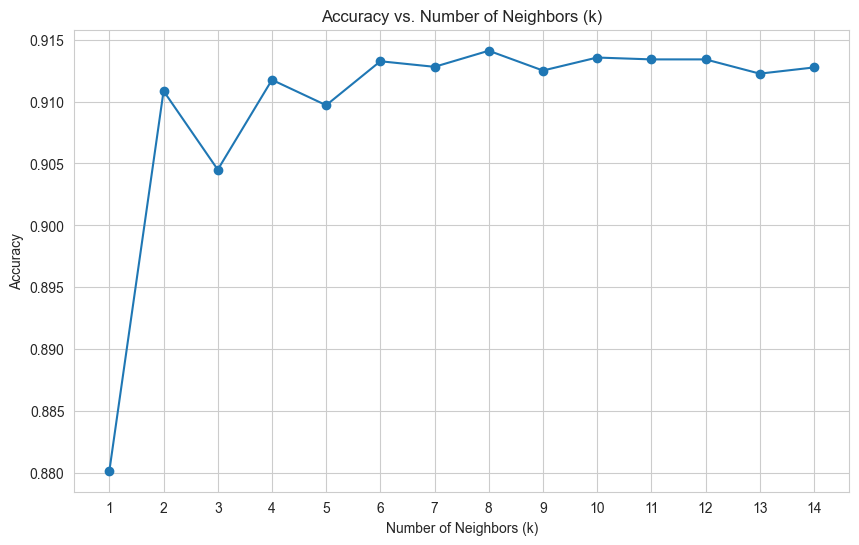

Classification Report for k = 8
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95     18254
         1.0       0.54      0.12      0.19      1746

    accuracy                           0.91     20000
   macro avg       0.73      0.55      0.57     20000
weighted avg       0.89      0.91      0.89     20000



In [32]:
predictors = ['DISTANCE_FROM_HOME', 'DISTANCE_FROM_LAST_TRANSACTION', 'ONLINE_ORDER', 'RATIO_TO_MEDIAN_PURCHASE_NORMALIZED', 'DISTANCE_VERY_FAR']
outcome = 'FRAUD'

# Extract predictors and outcome variable from the dataset
X = subset_data[predictors]
y = subset_data[outcome]

# Split data into training and validation sets
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=42)

# Initialize a list to store results
results = []

# Train a KNN classifier for different values of k
for k in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_X, train_y)
    y_pred = knn.predict(valid_X)
    accuracy = accuracy_score(valid_y, y_pred)
    results.append({'k': k, 'accuracy': accuracy})

# Display the results and plot the accuracy for different values of k
plt.figure(figsize=(10, 6))
for result in results:
    print(f"k = {result['k']}, Accuracy = {result['accuracy']:.4f}")
    
k_values = [result['k'] for result in results]
accuracies = [result['accuracy'] for result in results]
plt.plot(k_values, accuracies, marker='o', linestyle='-')
plt.title('Accuracy vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(range(1, 15))
plt.show()

# Get the best k value
best_k = max(results, key=lambda x: x['accuracy'])['k']

# Train the KNN classifier with the best k value
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(train_X, train_y)

# Get predictions on the validation set using the best k value
best_valid_preds = best_knn.predict(valid_X)

# Generate classification report for the best k value
class_report = classification_report(valid_y, best_valid_preds)

# Print the classification report
print("Classification Report for k =", best_k)
print(class_report)

### Decision Tree

In [33]:
predictors = ['DISTANCE_FROM_HOME', 'DISTANCE_FROM_LAST_TRANSACTION', 'ONLINE_ORDER', 'RATIO_TO_MEDIAN_PURCHASE_NORMALIZED', 'DISTANCE_VERY_FAR']
outcome = 'FRAUD'

# Extract predictors and outcome variable from the dataset
X = subset_data[predictors]
y = subset_data[outcome]

# Split data into training and validation sets
train_X, valid_X, train_y, valid__y = train_test_split(X, y, test_size=0.4, random_state=42)

# Initialize and fit the Decision Tree classifier
model = DecisionTreeClassifier()
model.fit(train_X, train_y)

# Predict on the validation set
valid__preds = model.predict(valid_X)

# Calculate accuracy
accuracy_dt = accuracy_score(valid__y, valid__preds)
print("Accuracy:", round(accuracy_dt, 4))

Accuracy: 0.9671


In [34]:
print(classification_report(valid__y, valid__preds))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     18254
         1.0       0.82      0.81      0.81      1746

    accuracy                           0.97     20000
   macro avg       0.90      0.89      0.90     20000
weighted avg       0.97      0.97      0.97     20000



### Logistic Regression

In [35]:
predictors = ['DISTANCE_FROM_HOME', 'DISTANCE_FROM_LAST_TRANSACTION', 'ONLINE_ORDER', 'RATIO_TO_MEDIAN_PURCHASE_NORMALIZED', 'DISTANCE_VERY_FAR']
outcome = 'FRAUD'

# Extract predictors and outcome variable from the dataset
X = data[predictors]
y = data[outcome]

# Split data into training and validation sets
train_X, valid_X, train_y, valid___y = train_test_split(X, y, test_size=0.4, random_state=42)

# Initialize and fit the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(train_X, train_y)

# Predict on the validation set
valid___preds = model.predict(valid_X)

# Calculate accuracy
accuracy_lr = accuracy_score(valid___y, valid___preds)
print("Accuracy:", round(accuracy_lr, 4))

Accuracy: 0.9353


In [36]:
report = classification_report(valid___y, valid___preds)

# Print classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97    365248
         1.0       0.79      0.35      0.48     34752

    accuracy                           0.94    400000
   macro avg       0.87      0.67      0.72    400000
weighted avg       0.93      0.94      0.92    400000



# Discussion | Conclusion

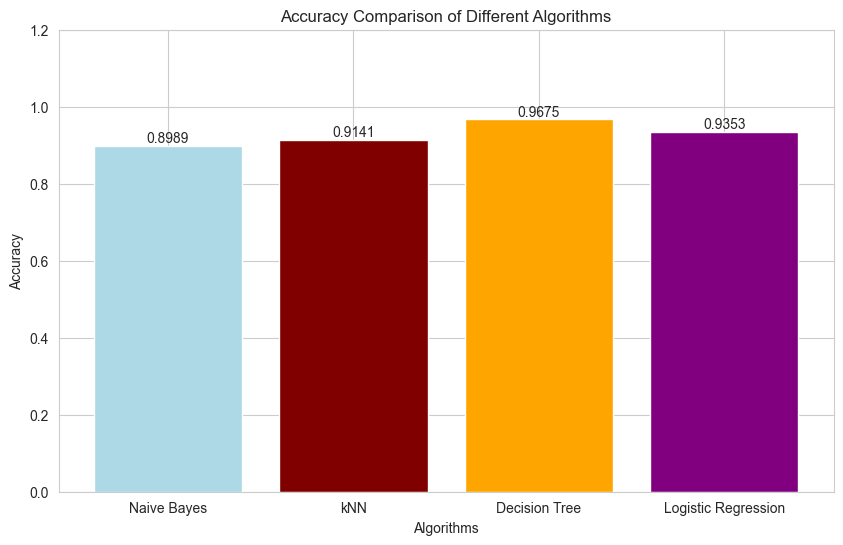

In [37]:
# Scores and algorithms
scores = [0.8989, 0.9141, 0.9675, 0.9353]
algorithms = ['Naive Bayes', 'kNN', 'Decision Tree', 'Logistic Regression']

# Plot histogram with different color schemes
plt.figure(figsize=(10, 6))
bars = plt.bar(algorithms, scores, color=['lightblue', 'maroon', 'orange', 'purple'])

# Add labels to the bars
for bar, score in zip(bars, scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{score:.4f}', ha='center', va='bottom')

plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Algorithms')
plt.ylim(0, 1.2) 
plt.show()